In [15]:
'''A basic introduction to MCMC for inference of dynamical systems models. '''

'A basic introduction to MCMC for inference of dynamical systems models. '

In [16]:
#!pip install diffrax

### Introduction

Markov Chain Monte Carlo (MCMC) provides a Monte Carlo approximation of the Bayesian posterior. The Metropolis–Hastings (MH) algorithm is one of the most fundamental and widely used MCMC methods. In MH, a proposal distribution is used to generate candidate states, and these candidates are accepted or rejected according to an acceptance probability. Many modern algorithms — such as Gibbs sampling and Hamiltonian Monte Carlo — can be viewed as variants of MCMC designed to improve efficiency in different settings.

### Example: Van der Pol Oscillator
In this example we use simple random walk Metropolis to learn a parameter of a dynamical system from noisy, partial observations. We first simulate the dynamical system and then generate noisy observations.

The dynamical system we consider here is the Van der Pol Oscillator, a two dimensional system with a single scalar parameter $\mu$. We will write the system in the following form

$$
\frac{dx}{dt} = \mu (x - \frac{1}{3} x^3 - y) \\
\frac{dy}{dt} = \frac{1}{\mu} x.
$$

The observations is the samples of $x$ at regular time intervals with additive Gaussian noise.  

In [17]:
from diffrax import diffeqsolve, ODETerm
from jax.scipy.stats import norm,poisson
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt



In [18]:
mu = jnp.log(1.0)

t_vec = jnp.linspace(0,20,400)

def rhs(t,state,args):

    x,y = state
    mu = args
    #exponentiate to enforce positivity
    mu = jnp.exp(mu)

    # Nonlinear cubic term introduces limit cycle behavior.
    dx = mu * (x - 1/3 * x**3 - y)
    # Coupling term creates slow–fast dynamics when mu is large.
    dy = 1/mu * x


    return jnp.array([dx,dy])

In [19]:
'''The model integrator. Takes the length of time to integrate, the initial condition, and a parameter vector.'''
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(rhs),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=ts) #At which points to save the output
        )
  return solution.ys

In [20]:
# Initializing the random number generator
rng_key = jax.random.PRNGKey(0)

# Split the key to avoid reusing the same key.
# JAX requires explicit key management.
noise_key,rng_key = jax.random.split(rng_key)

'''Simulate model'''
# Initial condition: x(0)=3.0, y(0)=0.5
full_state = model(t_vec,jnp.array([3.,0.5]),(mu))

# Generate noisy observations of the first state component x(t) with additive Gaussian noise ~N(0,1).
noise_std = 1.0
observations = full_state[:,0] + noise_std * jax.random.normal(noise_key,shape = full_state[:,0].shape)



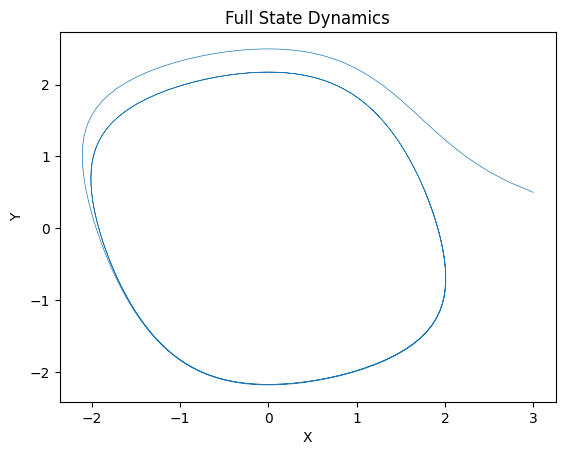

In [21]:
# Numerical solution of the ODE in x(t), y(t)
plt.plot(full_state[:,0],full_state[:,1],lw = 0.5)
plt.title('Full State Dynamics')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

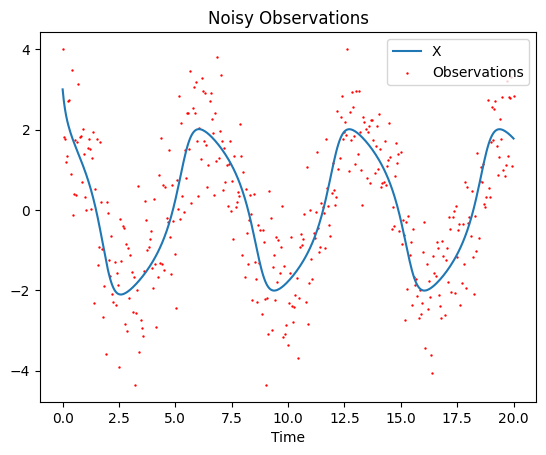

In [22]:
# Numerical solution of the ODE in t,x(t)
# We assume that the obervations are the red dots
plt.title('Noisy Observations')
plt.plot(t_vec,full_state[:,0],label = 'X')
plt.scatter(t_vec,observations,s = 0.5,color = 'red', label = 'Observations')
plt.xlabel('Time')
plt.legend()
plt.show()

Now that we have our dynamics and our noisy observations, we can construct the Bayesian inference problem. First we will define a prior and likelihood function for our data.

Our prior for this problem is essentially arbitrary. We will chose a Gaussian prior with mean zero and variance $\tau^2$.

In [23]:
'''Prior'''
tau = 5.0

@jax.jit
def log_prior(par,tau):
    mu = par
    return jax.scipy.stats.norm.logpdf(mu,scale = tau)

Now for the likelihood. We will define our likelihood based on our observational noise for this toy model. Obviously in practice this observational noise will not be known exactly so we will need to choose our likelihood function based on heuristics or an informed guess.

In [24]:
@jax.jit
def log_likelihood(par):
  mu = par
  model_output = model(t_vec,jnp.array([3.,0.5]),(mu))
  return jnp.sum(jax.scipy.stats.norm.logpdf(observations, model_output[:,0],scale = noise_std))

## Random-Walk Metropolis (Metropolis–Hastings) for Van der Pol Parameter Inference

To construct a Markov Chain targeting the posterior distribution

$$
\begin{aligned}
P(\theta|Y_{1:t}) = \frac{P(Y_{1:t}|\theta)P(\theta)}{P(Y_{1:t})}
\end{aligned}
$$

where $P(\theta)$ is the prior and $P(Y_{1:t}|\theta)$ is the likelihood we will use the Metropolis algorithm. The Metropolis algorithm proceeds as follows.

### Inputs / Hyperparameters

- Time grid: `t_vec = linspace(t0, t1, T)`  
- Initial condition: `y0 = [3.0, 0.5]`
- Observation noise std: `noise_std`
- Gaussian prior on θ: `τ`
- MCMC iterations: `N`
- Proposal std: `s`
- Burn-in: `B `

---

### Outputs

- Posterior samples: `thetas` = $\{\theta_{0}, \theta_1,\dots, \theta_{N-1}\}$
- Log posterior trace: `LL` = $\{\log \pi(\theta_{0}),\dots, \log \pi(\theta_{N-1})\}$
- Acceptance indicators: `acceptances` = $\{0,1,\dots\}$

---

## Pesudo code

We build a Markov chain ${\theta_{0}, \theta_{1},\dots, \theta_{N-1}}$ targeting the posterior.

### Algorithm

**Initialize**
1. Draw initial sample from prior:
   - $\theta_{0}$ ~ Normal(0, $\tau^2$)
2. Compute:
   - $L_{\theta_{0}}$ ← LOG_POSTERIOR($\theta_{0}$)
3. Store:
   - `thetas = [θ₀]`
   - `LL = [L₀]`
   - `acceptances = []`

**For** k = 1, 2, …, N−1:
1. **Propose** (random-walk):
   - $\theta^*$ ← $\theta_{k−1}$ + s · Normal(0,1)
2. **Compute** proposed log posterior:
   - L* ← LOG_POSTERIOR(θ*)
3. **Acceptance log-ratio** (symmetric proposal ⇒ no proposal terms):
   - $\alpha$ ← $L^{*}$ − $L_{k−1}$
4. **Accept/Reject**
   - Draw u ~ Uniform(0,1)
   - If $log(u) < \alpha$:
     - $\theta_k$ ← $\theta^*$
     - L_k ← L*
     - append 1 to `acceptances`
   - Else:
     - $\theta_k$ ← $\theta_{k−1}$
     - $L_k$ ← $L_{k−1}$
     - append 0 to `acceptances`
5. Append θ_k to `thetas` and L_k to `LL`
6. (Optional) Print diagnostics:
   - acceptance_rate = mean(acceptances)
   - current μ estimate = $\exp(\theta_k)$

**End For**



In [25]:
thetas = []
LL = []

sample_key,rng_key = jax.random.split(rng_key)

theta_0 = tau * jax.random.normal(sample_key)
thetas.append(theta_0)

LL_0 = log_likelihood(theta_0) + log_prior(theta_0,tau)
LL.append(LL_0)

##MH
iterations = 10000

proposal_std = 0.15

acceptances = []

for iter in range(1,iterations):
    ##Proposal
    prop_key,rng_key = jax.random.split(rng_key)
    theta_prop = thetas[-1] + proposal_std * jax.random.normal(prop_key)

    LL_prop = log_likelihood(theta_prop) + log_prior(theta_prop,tau)
    alpha = LL_prop - LL[-1]

    rng_key, accept_key = jax.random.split(rng_key)
    if jnp.log(jax.random.uniform(minval = 0., maxval = 1., key = accept_key)) < alpha:
        LL.append(LL_prop)
        thetas.append(theta_prop)
        acceptances.append(1)

    else:
        LL.append(LL[-1])
        thetas.append(thetas[-1])
        acceptances.append(0)

    print(f"iteration: {iter} | Acceptance rate: {sum(acceptances)/iter} | mu: {jnp.exp(thetas[-1])}")






iteration: 1 | Acceptance rate: 1.0 | mu: 2.0401337146759033
iteration: 2 | Acceptance rate: 0.5 | mu: 2.0401337146759033
iteration: 3 | Acceptance rate: 0.6666666666666666 | mu: 2.009962797164917
iteration: 4 | Acceptance rate: 0.75 | mu: 1.7983804941177368
iteration: 5 | Acceptance rate: 0.8 | mu: 1.3357627391815186
iteration: 6 | Acceptance rate: 0.6666666666666666 | mu: 1.3357627391815186
iteration: 7 | Acceptance rate: 0.7142857142857143 | mu: 1.2215934991836548
iteration: 8 | Acceptance rate: 0.75 | mu: 1.0548954010009766
iteration: 9 | Acceptance rate: 0.6666666666666666 | mu: 1.0548954010009766
iteration: 10 | Acceptance rate: 0.6 | mu: 1.0548954010009766
iteration: 11 | Acceptance rate: 0.5454545454545454 | mu: 1.0548954010009766
iteration: 12 | Acceptance rate: 0.5 | mu: 1.0548954010009766
iteration: 13 | Acceptance rate: 0.46153846153846156 | mu: 1.0548954010009766
iteration: 14 | Acceptance rate: 0.42857142857142855 | mu: 1.0548954010009766
iteration: 15 | Acceptance rate: 

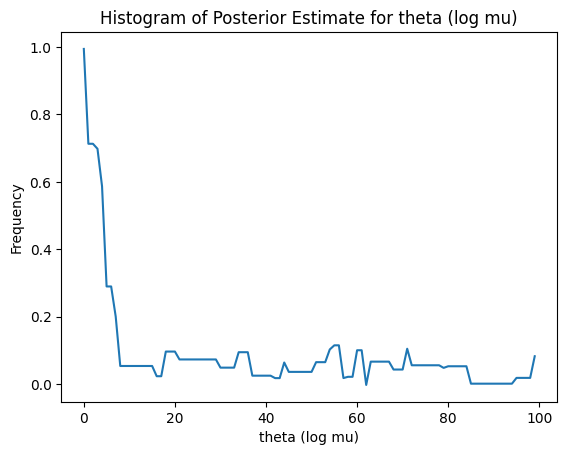

In [26]:
plt.title('Histogram of Posterior Estimate for theta (log mu)')
plt.plot(jnp.array(thetas[:100]))
plt.xlabel('theta (log mu)')
plt.ylabel('Frequency')
plt.show()

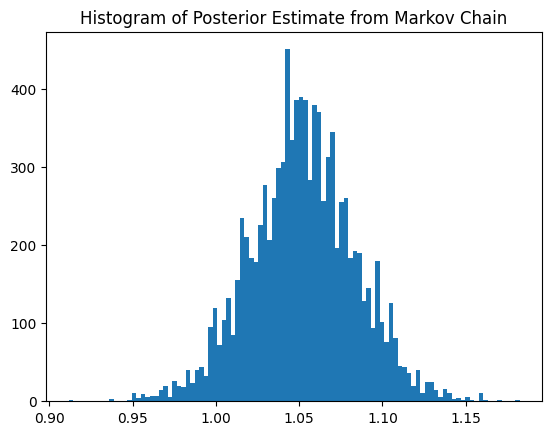

In [27]:
burn_in = 100
plt.title('Histogram of Posterior Estimate from Markov Chain')
plt.hist(jnp.exp(jnp.array(thetas[burn_in:])),bins = 100)
plt.show()


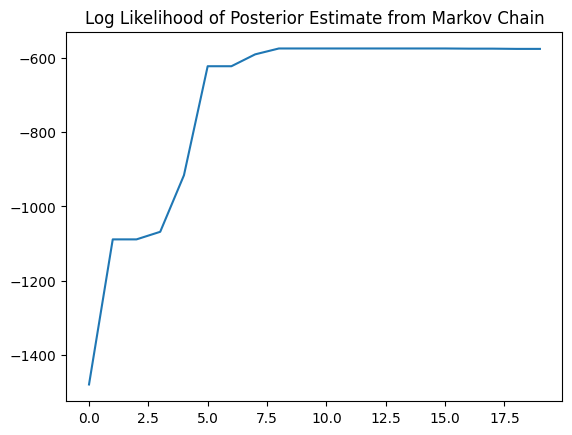

In [28]:
plt.title('Log Likelihood of Posterior Estimate from Markov Chain')
plt.plot(LL[:20])
plt.show()

### Exercise A1 — Proposal Scale and Acceptance Rate

Modify the proposal standard deviation `proposal_std` in the random-walk Metropolis algorithm. Try values such as:
- 0.01
- 0.05
- 0.15
- 0.5
- 1.0

**Questions**

- What happens to the acceptance rate as `proposal_std` increases?
- Is a very high or very low acceptance rate desirable?

---

### Exercise A2 — Sensitivity to Initialization

Run the MCMC algorithm with different initial values:

- $ \theta_0 = 0 $
- $ \theta_0 = 5 $
- $ \theta_0 = -5 $

Keep all other settings fixed.

**Questions**

- Do the chains converge to the same distribution?
- How long does the parameter $\theta$ take to be stabilized for each case?

---

### Exercise A3 — Prior Sensitivity

Change the prior variance $( \tau^2 )$ in
$
\theta \sim \mathcal{N}(0, \tau^2)
$
to
- $ \tau = 0.1 $
- $ \tau = 1 $
- $ \tau = 20 $

**Questions**

- How does tightening or loosening the prior affect the posterior?

---

### Exercise A4 — Observation Noise Misspecification

Generate synthetic data using $\sigma_{\text{true}} = 1$

But perform inference assuming:

- $ \sigma = 0.5 $
- $ \sigma = 2.0 $

**Questions**

- How does the posterior uncertainty change?
- Does the posterior mean shift?
- Why does noise misspecification affect parameter inference?

---

### Exercise B1 — Infer Noise Level

Extend the parameter vector to $
(\theta, \eta)$, where $
\mu = \exp(\theta)$, $\sigma = \exp(\eta)$.
Apply independent Gaussian priors on $\theta$ and $\eta$.

1. Modify the log-likelihood to depend on $ \sigma $.
2. Implement a 2D random-walk Metropolis sampler.
3. Plot the joint posterior samples.

**Questions**

- Is there posterior correlation between $ \mu $ and $ \sigma $?
- Does inference become harder in higher dimension?

---

### Exercise C1 — Infer Constant Transmission Rate $\beta$

Assume all parameters are fixed except the transmission rate $\beta$. Therefore, $
\theta = \log \beta,
\quad
\beta = \exp(\theta)
$

1. Implement the SIHR ODE system.
2. Simulate synthetic hospitalization data.
3. Choose an observation model:

   - Poisson likelihood for daily new hospitalizations
   - OR Gaussian likelihood for hospitalized census

4. Define:
   - log prior for $ \theta $
   - log likelihood
5. Run random-walk Metropolis.
6. Plot posterior histogram of $ \beta $.

**Questions**

- Does the posterior recover the true $ \beta $?
- How sensitive is inference to the observation model?
- Is the posterior wider than in the Van der Pol example? Why?